In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import operator
from wordcloud import WordCloud,STOPWORDS
import matplotlib as mpl
import itertools

##  Feature Exploration

Before diving into clustering, it's important to understand the dataset's structure and the nature of the features. Feature exploration helps us:

- Identify missing or inconsistent values.
- Understand the variability and richness of textual fields like `title`, `abstract`, and `keywords`.
- Get an initial sense of how the data is distributed.
- Decide which features may be useful for downstream tasks like clustering or topic modeling.



🔹 First few rows:
                                               title  \
0              Kernelized Bayesian Transfer Learning   
1  "Source Free" Transfer Learning for Text Class...   
2  A Generalization of Probabilistic Serial to Ra...   
3         Lifetime Lexical Variation in Social Media   
4  Hybrid Singular Value Thresholding for Tensor ...   

                                             authors  \
0                  Mehmet Gönen and Adam A. Margolin   
1  Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yu...   
2                      Haris Aziz and Paul Stursberg   
3  Liao Lizi, Jing Jiang, Ying Ding, Heyan Huang ...   
4   Xiaoqin Zhang, Zhengyuan Zhou, Di Wang and Yi Ma   

                                              groups  \
0           Novel Machine Learning Algorithms (NMLA)   
1  AI and the Web (AIW)\nNovel Machine Learning A...   
2          Game Theory and Economic Paradigms (GTEP)   
3                        NLP and Text Mining (NLPTM)   
4  Knowledge Representation 

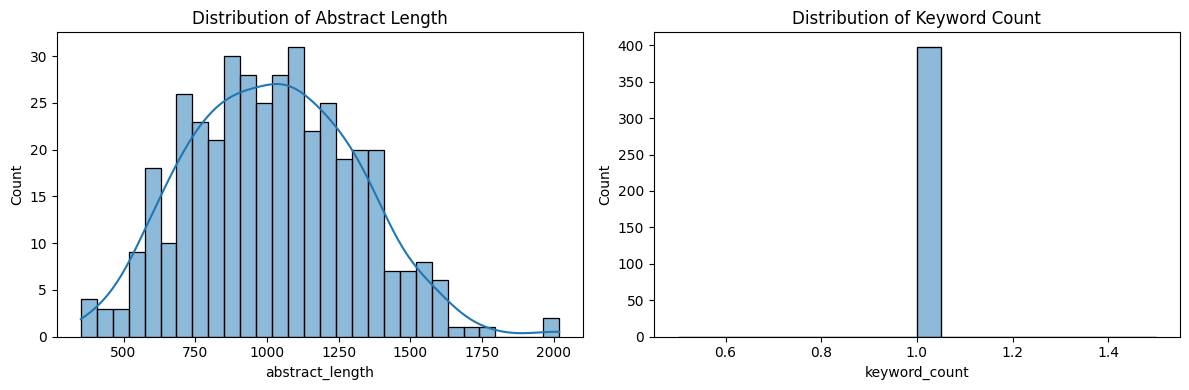

In [3]:

# Load dataset
data_train = pd.read_csv('[UCI] AAAI-14 Accepted Papers - Papers.csv')  # Adjust path if needed

# Show the first few rows
print("🔹 First few rows:")
print(data_train.head())

# Show column names
print("\n🔹 Columns in the dataset:")
print(data_train.columns.tolist())

# Check for missing values
print("\n🔹 Missing values per column:")
print(data_train.isnull().sum())

# Basic stats: Number of unique entries per column
print("\n🔹 Unique values per column:")
for col in data_train.columns:
    print(f"{col}: {data_train[col].nunique()} unique values")

# Length of text in abstract, title, and keywords
data_train['abstract_length'] = data_train['abstract'].fillna('').apply(len)
data_train['title_length'] = data_train['title'].fillna('').apply(len)
data_train['keyword_count'] = data_train['keywords'].fillna('').apply(lambda x: len(x.split(',')))

print("\n🔹 Summary of text lengths:")
print(data_train[['abstract_length', 'title_length', 'keyword_count']].describe())


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(data_train['abstract_length'], bins=30, kde=True)
plt.title('Distribution of Abstract Length')

plt.subplot(1, 2, 2)
sns.histplot(data_train['keyword_count'], bins=20, kde=True)
plt.title('Distribution of Keyword Count')

plt.tight_layout()
plt.show()


**Insights**

Abstract lengths mostly range from 600 to 1400.

Peak around 1000–1100 characters.

Slight right skew in abstract lengths.

All entries have exactly 1 keyword set.

Keyword column likely not split properly.

In [4]:
data_train = data_train[['title', 'groups', 'keywords', 'topics']]

In [5]:
print(len(data_train))
data_train.head()

398


title  \
0              Kernelized Bayesian Transfer Learning   
1  "Source Free" Transfer Learning for Text Class...   
2  A Generalization of Probabilistic Serial to Ra...   
3         Lifetime Lexical Variation in Social Media   
4  Hybrid Singular Value Thresholding for Tensor ...   

                                              groups  \
0           Novel Machine Learning Algorithms (NMLA)   
1  AI and the Web (AIW)\nNovel Machine Learning A...   
2          Game Theory and Economic Paradigms (GTEP)   
3                        NLP and Text Mining (NLPTM)   
4  Knowledge Representation and Reasoning (KRR)\n...   

                                            keywords  \
0  cross-domain learning\ndomain adaptation\nkern...   
1  Transfer Learning\nAuxiliary Data Retrieval\nT...   
2  social choice theory\nvoting\nfair division\ns...   
3  Generative model\nSocial Networks\nAge Prediction   
4  tensor completion\nlow-rank recovery\nhybrid s...   

                                              topics  
0  APP: Biomedical / Bioinformatics\nNMLA: Bayesi...  
1  AIW: Knowledge acquisition from the web\nAIW: ...  
2    GTEP: Game Theory\nGTEP: Social Choice / Voting  
3  AIW: Web personalization and user modeling\nNL...  
4  KRR: Knowledge Representation (General/Other)\...

###  Insights from Feature Exploration

- Some missing values may exist in certain fields, but most of the core columns are relatively complete.
- Abstracts tend to vary significantly in length — this can influence how we process and vectorize them later.
- Keyword counts also vary, indicating the number of concepts or topics assigned to each paper.
- These distributions give us useful signals on which fields to prioritize for clustering (e.g., `abstract` and `keywords` seem most content-rich).


**Data Transformation For Modeling**

In [6]:
s = data_train['groups'].str.split('\n').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'groups'
del data_train['groups']
data_train = data_train.join(s).reset_index()
data_train['flags'] = pd.Series(np.ones(len(data_train)),  
index=data_train.index)
data_train.head()

C:\Users\T L S\AppData\Local\Temp\ipykernel_11376\1939959156.py:1: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  s = data_train['groups'].str.split('\n').apply(pd.Series, 1).stack()


index                                              title  \
0      0              Kernelized Bayesian Transfer Learning   
1      1  "Source Free" Transfer Learning for Text Class...   
2      1  "Source Free" Transfer Learning for Text Class...   
3      2  A Generalization of Probabilistic Serial to Ra...   
4      3         Lifetime Lexical Variation in Social Media   

                                            keywords  \
0  cross-domain learning\ndomain adaptation\nkern...   
1  Transfer Learning\nAuxiliary Data Retrieval\nT...   
2  Transfer Learning\nAuxiliary Data Retrieval\nT...   
3  social choice theory\nvoting\nfair division\ns...   
4  Generative model\nSocial Networks\nAge Prediction   

                                              topics  \
0  APP: Biomedical / Bioinformatics\nNMLA: Bayesi...   
1  AIW: Knowledge acquisition from the web\nAIW: ...   
2  AIW: Knowledge acquisition from the web\nAIW: ...   
3    GTEP: Game Theory\nGTEP: Social Choice / Voting   
4  AIW: Web personalization and user modeling\nNL...   

                                      groups  flags  
0   Novel Machine Learning Algorithms (NMLA)    1.0  
1                       AI and the Web (AIW)    1.0  
2   Novel Machine Learning Algorithms (NMLA)    1.0  
3  Game Theory and Economic Paradigms (GTEP)    1.0  
4                NLP and Text Mining (NLPTM)    1.0

**Matrix Creation**

In [7]:
def matrix_from_df(data_train):
    matrix = data_train.pivot_table(index = ['title'], columns=['groups'], 
    values='flags')
    matrix = matrix.fillna(0).reset_index()
    x_cols = matrix.columns[1:]
    return matrix, x_cols

In [8]:
matrix, x_cols = matrix_from_df(data_train)
matrix.head()

groups                                              title  \
0       "Source Free" Transfer Learning for Text Class...   
1       A Characterization of the Single-Peaked Single...   
2       A Computational Method for (MSS,CoMSS) Partiti...   
3              A Control Dichotomy for Pure Scoring Rules   
4       A Convex Formulation for Semi-supervised Multi...   

groups  AI and the Web (AIW)  Applications (APP)  Cognitive Modeling (CM)  \
0                        1.0                 0.0                      0.0   
1                        0.0                 0.0                      0.0   
2                        0.0                 0.0                      0.0   
3                        0.0                 0.0                      0.0   
4                        0.0                 0.0                      0.0   

groups  Cognitive Systems (CS)  Computational Sustainability and AI (CSAI)  \
0                          0.0                                         0.0   
1                          0.0                                         0.0   
2                          0.0                                         0.0   
3                          0.0                                         0.0   
4                          0.0                                         0.0   

groups  Game Playing and Interactive Entertainment (GPIE)  \
0                                                     0.0   
1                                                     0.0   
2                                                     0.0   
3                                                     0.0   
4                                                     0.0   

groups  Game Theory and Economic Paradigms (GTEP)  \
0                                             0.0   
1                                             1.0   
2                                             0.0   
3                                             1.0   
4                                             0.0   

groups  Heuristic Search and Optimization (HSO)  \
0                                           0.0   
1                                           0.0   
2                                           1.0   
3                                           0.0   
4                                           0.0   

groups  Human-Computation and Crowd Sourcing (HCC)  ...  \
0                                              0.0  ...   
1                                              0.0  ...   
2                                              0.0  ...   
3                                              0.0  ...   
4                                              0.0  ...   

groups  Multiagent Systems (MAS)  NLP and Knowledge Representation (NLPKR)  \
0                            0.0                                       0.0   
1                            1.0                                       0.0   
2                            0.0                                       0.0   
3                            0.0                                       0.0   
4                            0.0                                       0.0   

groups  NLP and Machine Learning (NLPML)  NLP and Text Mining (NLPTM)  \
0                                    0.0                          0.0   
1                                    0.0                          0.0   
2                                    0.0                          0.0   
3                                    0.0                          0.0   
4                                    0.0                          0.0   

groups  Novel Machine Learning Algorithms (NMLA)  \
0                                            1.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

groups  Planning and Scheduling (PS)  Reasoning under Uncertainty (RU)  \
0                                0.0                      

**Elbow Method & Variance Explained**

Text(0.5, 1.0, 'Elbow for KMeans clustering')

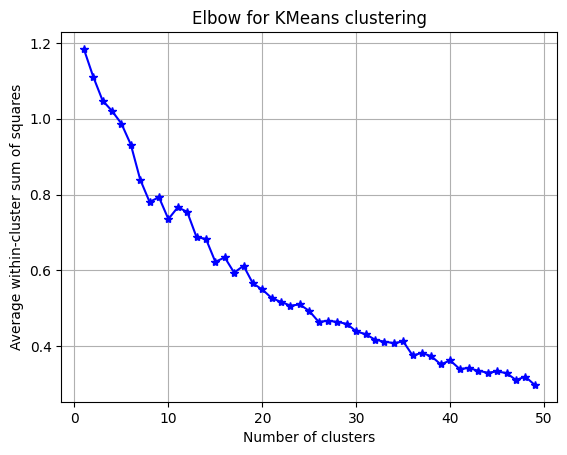

In [9]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

Text(0.5, 1.0, 'Elbow for KMeans clustering')

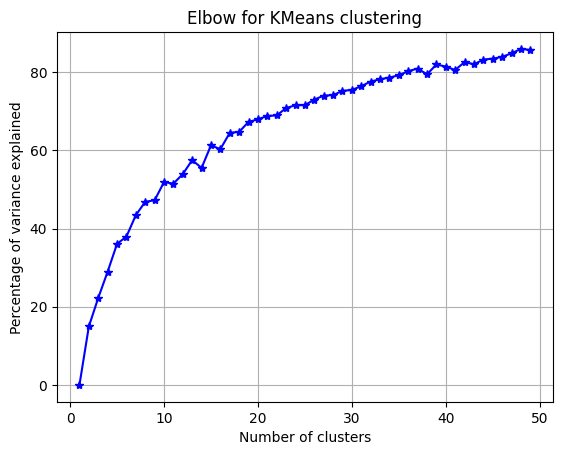

In [10]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(X)**2)/X.shape[0]
bss = tss-wcss
kIdx = 10-1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

**Silhouette Score**

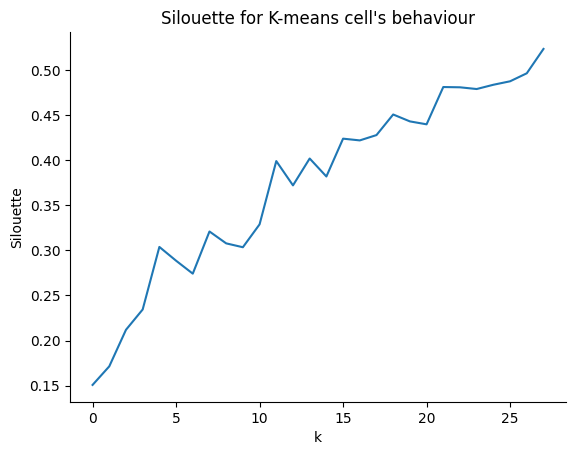

In [11]:
s = []
for n_clusters in range(2,30):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    s.append(silhouette_score(X, labels, metric='euclidean'))
plt.plot(s)
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")
sns.despine()

**Applying K-Mean Clustering with K=9**

In [12]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
cluster = KMeans(n_clusters = 9, random_state = 2)
matrix['cluster'] = cluster.fit_predict(X)
matrix.cluster.value_counts()

cluster
3    128
7     45
0     42
5     41
2     32
6     32
4     32
8     30
1     14
Name: count, dtype: int64

**PCA**

In [13]:
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()
customer_clusters = matrix[['title', 'cluster', 'x', 'y']]
customer_clusters.head()

groups                                              title  cluster         x  \
0       "Source Free" Transfer Learning for Text Class...        0  0.615810   
1       A Characterization of the Single-Peaked Single...        2 -0.756838   
2       A Computational Method for (MSS,CoMSS) Partiti...        7 -0.287956   
3              A Control Dichotomy for Pure Scoring Rules        6 -0.521295   
4       A Convex Formulation for Semi-supervised Multi...        5  0.198578   

groups         y  
0      -0.060295  
1       0.971322  
2      -0.216148  
3       0.570206  
4      -0.129668

e:\New folder (2)\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


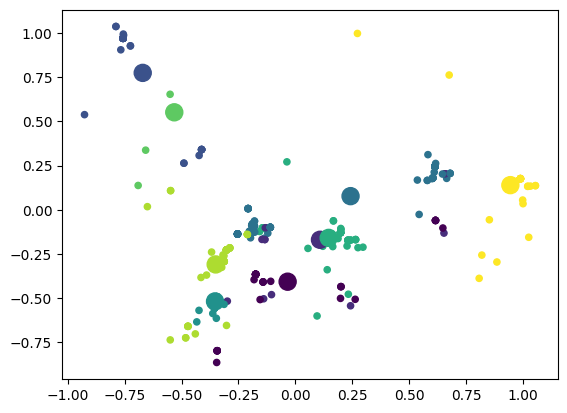

In [14]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))
plt.scatter(customer_clusters['x'], customer_clusters['y'], s = 20, 
c=customer_clusters['cluster'])
plt.scatter(cluster_centers['x'], cluster_centers['y'], s = 150, c=cluster_centers['cluster'])

**Merging Matrix**

In [15]:
customer_clusters.columns.name = None
df = data_train.merge(customer_clusters, on='title')
df.head()

index                                              title  \
0      0              Kernelized Bayesian Transfer Learning   
1      1  "Source Free" Transfer Learning for Text Class...   
2      1  "Source Free" Transfer Learning for Text Class...   
3      2  A Generalization of Probabilistic Serial to Ra...   
4      3         Lifetime Lexical Variation in Social Media   

                                            keywords  \
0  cross-domain learning\ndomain adaptation\nkern...   
1  Transfer Learning\nAuxiliary Data Retrieval\nT...   
2  Transfer Learning\nAuxiliary Data Retrieval\nT...   
3  social choice theory\nvoting\nfair division\ns...   
4  Generative model\nSocial Networks\nAge Prediction   

                                              topics  \
0  APP: Biomedical / Bioinformatics\nNMLA: Bayesi...   
1  AIW: Knowledge acquisition from the web\nAIW: ...   
2  AIW: Knowledge acquisition from the web\nAIW: ...   
3    GTEP: Game Theory\nGTEP: Social Choice / Voting   
4  AIW: Web personalization and user modeling\nNL...   

                                      groups  flags  cluster         x  \
0   Novel Machine Learning Algorithms (NMLA)    1.0        3  0.613870   
1                       AI and the Web (AIW)    1.0        0  0.615810   
2   Novel Machine Learning Algorithms (NMLA)    1.0        0  0.615810   
3  Game Theory and Economic Paradigms (GTEP)    1.0        6 -0.521295   
4                NLP and Text Mining (NLPTM)    1.0        3 -0.183192   

          y  
0  0.245408  
1 -0.060295  
2 -0.060295  
3  0.570206  
4 -0.090091

**WordCloud & its Plotting**

In [16]:
def wordcloud_object(word_string):
    FONT_ROOT = './fonts/'
    wordcloud = WordCloud(font_path=FONT_ROOT + 'arial.ttf',stopwords=STOPWORDS, background_color='black', width=1200, height=1000).generate(' '.join(word_string))
    return wordcloud

In [17]:
def plot_wordcloud(df, clusters, pivot):
    fig = plt.figure(figsize=(15,29.5))
    for cluster in range(clusters):
        List_ = []
        for x in df[df['cluster']==cluster][pivot]:
            try:
                List_.extend(x.split('\n'))
            except:
                pass
        if List_:
            ax = fig.add_subplot(5,2,cluster+1)
            wordcloud = wordcloud_object(List_)
            plt.title('Cluster: %d'%(cluster+1))
            ax.imshow(wordcloud)
            ax.axis('off')

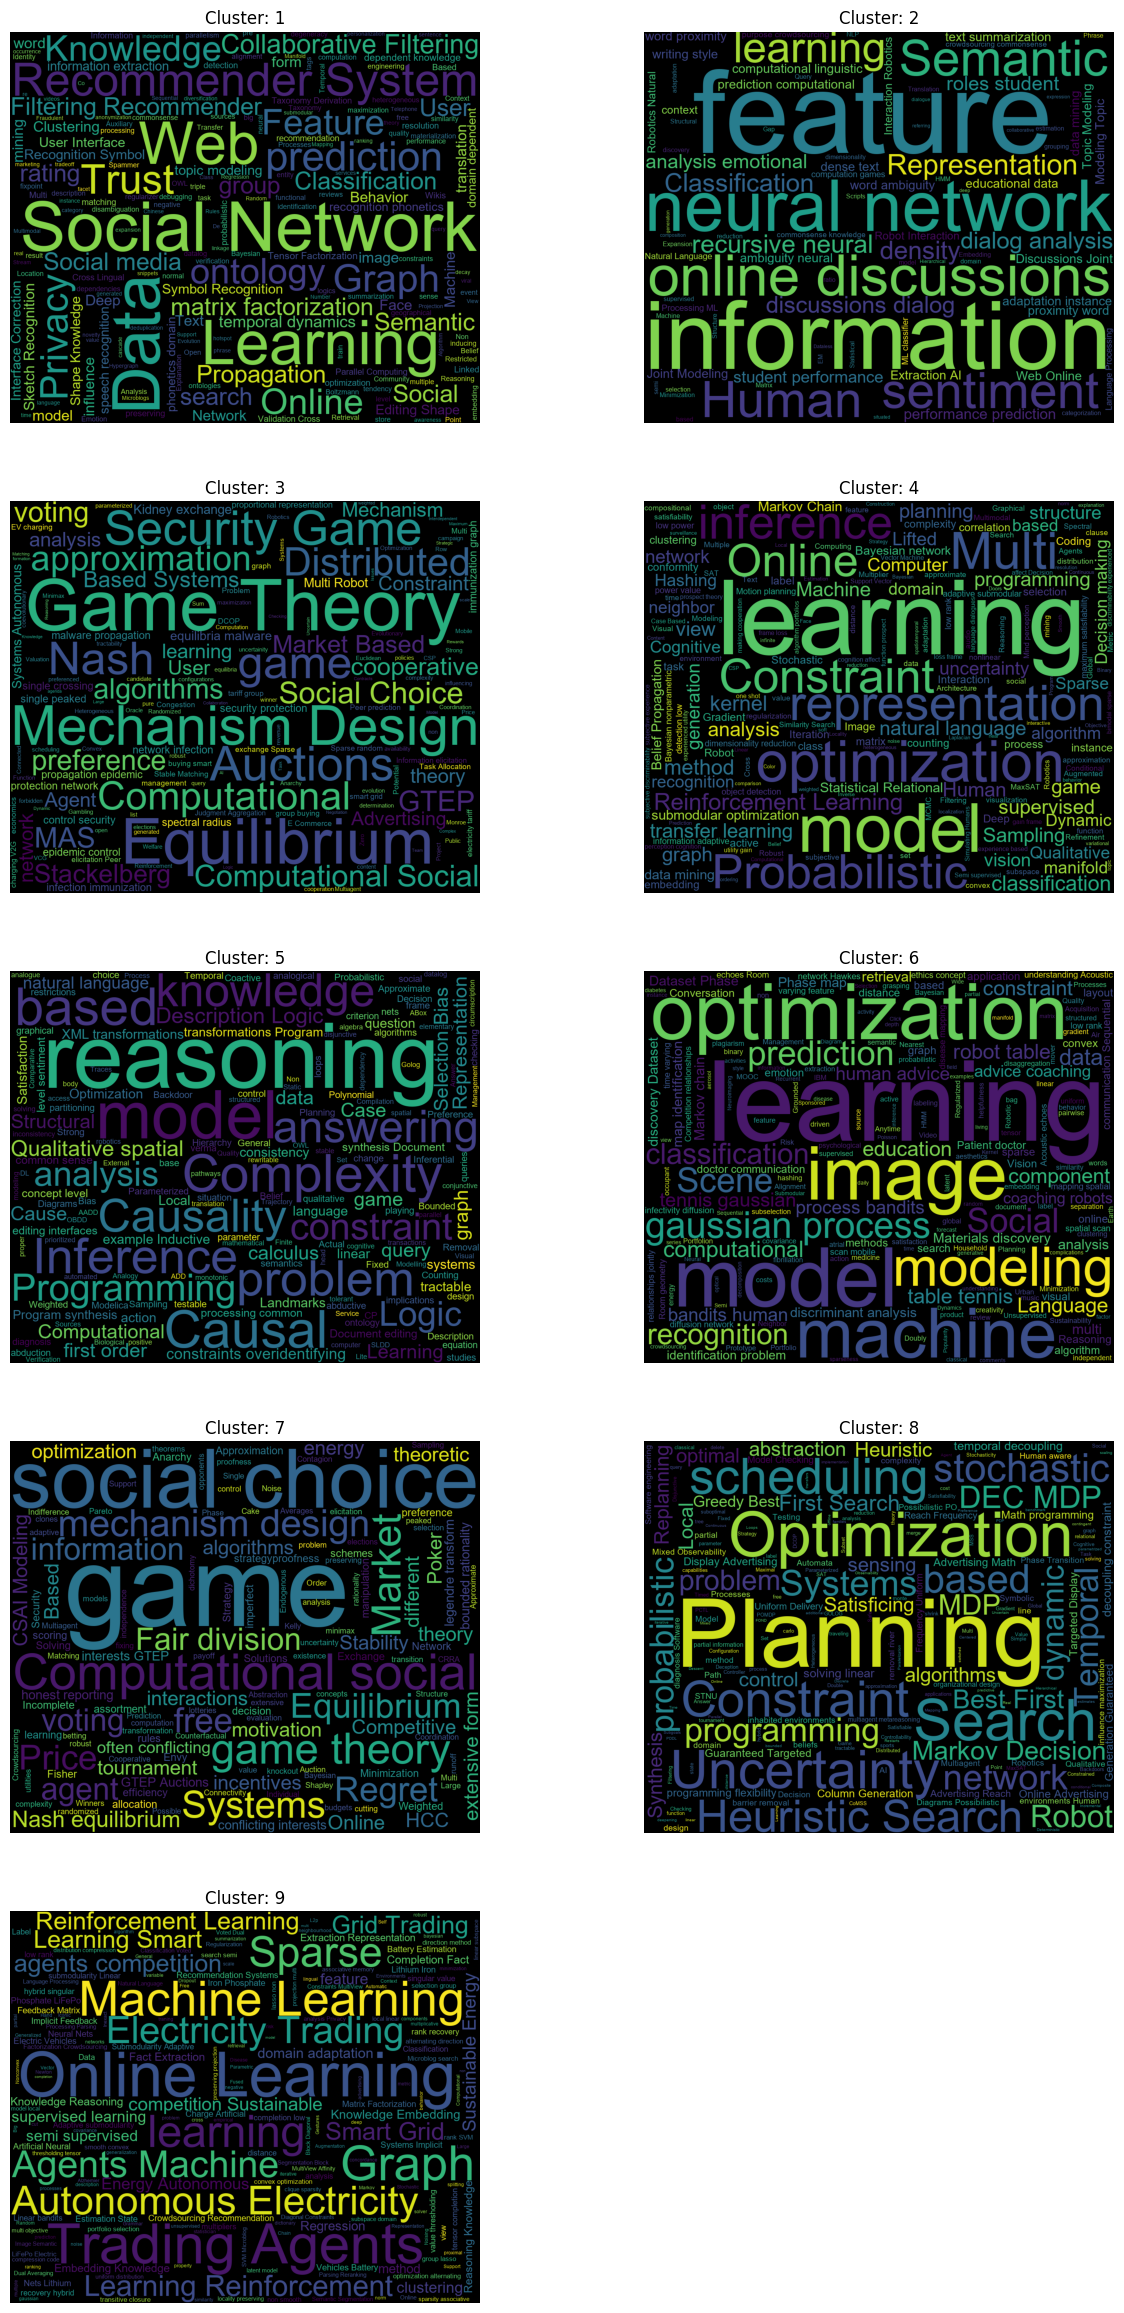

In [18]:
plot_wordcloud(df, cluster.n_clusters, 'keywords')

**Insights**

Cluster 1 focuses on social networks, recommender systems, and privacy in online platforms.

Cluster 2 emphasizes neural networks, sentiment analysis, and human interaction in information processing.

Cluster 3 centers on game theory, auctions, and mechanism design in computational environments.

Cluster 4 includes probabilistic models, optimization, and multi-task learning under uncertainty.

Cluster 5 explores reasoning, causal inference, logic programming, and complexity analysis.

Cluster 6 highlights image modeling, optimization, and machine learning techniques in vision tasks.

Cluster 7 involves game theory in social systems, fairness, and agent-based decision-making.

Cluster 8 relates to planning, scheduling, search heuristics, and decision-making under uncertainty.

Cluster 9 focuses on reinforcement learning, trading agents, and smart system applications like energy and electricity.


**All Enteries of Cluster**

In [21]:

def perform_cluster_group_audit(clusters, term):
        for cluster in clusters:
            df_cluster = df[df['cluster'] == cluster]
            print('Cluster number: %d' % (cluster + 1))

            # Extract and flatten keywords
            keywords = list(df_cluster['keywords'])
            keywords = [keyword.split('\n') for keyword in keywords]
            keywords = [item for sublist in keywords for item in sublist]

            # Filter and normalize keywords based on search term
            keywords = [keyword.lower() for keyword in keywords if term in keyword.lower()]

            # Count frequencies
            keywords_freq = {x: keywords.count(x) for x in keywords}

            # Sort and print keyword frequencies
            print(sorted(keywords_freq.items(), key=operator.itemgetter(1), reverse=True))
            print('\n')


In [22]:
perform_cluster_group_audit([0,4], 'search')

Cluster number: 1
[('web search personalization', 1), ('entity search', 1), ('real-time web search', 1), ('search snippets', 1), ('search result diversification', 1)]


Cluster number: 5
[]




In [23]:
perform_cluster_group_audit([2,3,6], 'social')

Cluster number: 3
[('computational social choice', 7), ('social welfare', 2), ('influencing social networks', 2)]


Cluster number: 4
[('social conformity', 2), ('social networks', 1)]


Cluster number: 7
[('computational social choice', 11), ('social choice theory', 2), ('social decision schemes', 2), ('randomized social choice', 1)]




In [25]:


def plot_results(X, Y_, means, covariances, index, title):
    color_iter = itertools.cycle([
        'b', 'g', 'red', 'm', 'y', 'navy', 'c',
        'cornflowerblue', 'gold', 'darkorange'
    ])

    splot = plt.subplot(2, 1, 1 + index)

    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue

        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], s=0.8, color=color)

        angle = np.arctan2(u[1], u[0])
        angle = 180. * angle / np.pi  # convert to degrees

        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(0.0, 0.1)
    plt.ylim(-0.2, 1.2)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


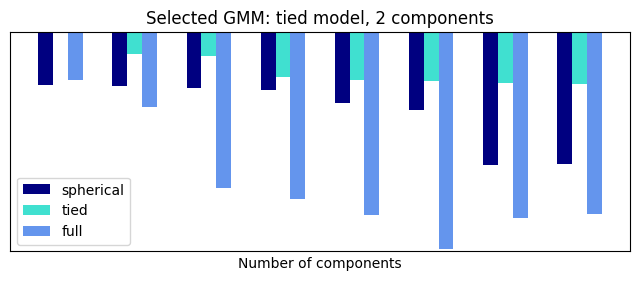

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
import itertools

# Your function to get a matrix from a DataFrame
# matrix, x_cols = matrix_from_df(data_train)

# Convert to matrix
X = matrix[x_cols].values  # `.as_matrix()` is deprecated; use `.values`

# To store model statistics
model_stats = []

# GMM parameters to try
n_components_range = range(2, 10)
cv_types = ['spherical', 'tied', 'full']

# Fit GMMs
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(
            n_components=n_components,
            covariance_type=cv_type,
            random_state=0
        )
        gmm.fit(X)
        model_stats.append({
            'name': f'{cv_type}_{n_components}',
            'model': gmm,
            'bic': gmm.bic(X)
        })

# Get BIC values and find best model
bic = np.array([m_type['bic'] for m_type in model_stats])
best_gmm = model_stats[bic.argmax()]
clf = best_gmm['model']

# Plotting setup
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bar = plt.bar(
        xpos,
        bic[i * len(n_components_range):(i + 1) * len(n_components_range)],
        width=.2,
        color=color
    )
    bars.append(bar)

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Predict using best GMM
labels = clf.predict(X)

# Function to visualize GMM result (assumes it's already defined)
# plot_results(X, labels, clf.means_, clf.covariances_, 1, 'GMM Result')

# Final plot settings
plt.xticks(())
plt.yticks(())
plt.title(
    f'Selected GMM: {best_gmm["name"].split("_")[0]} model, '
    f'{best_gmm["name"].split("_")[1]} components'
)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()


In [27]:
matrix['cluster'] = labels
matrix.cluster.value_counts()

cluster
0    246
1    150
Name: count, dtype: int64

In [28]:
customer_clusters.columns.name = None
df = data_train.merge(customer_clusters, on='title')

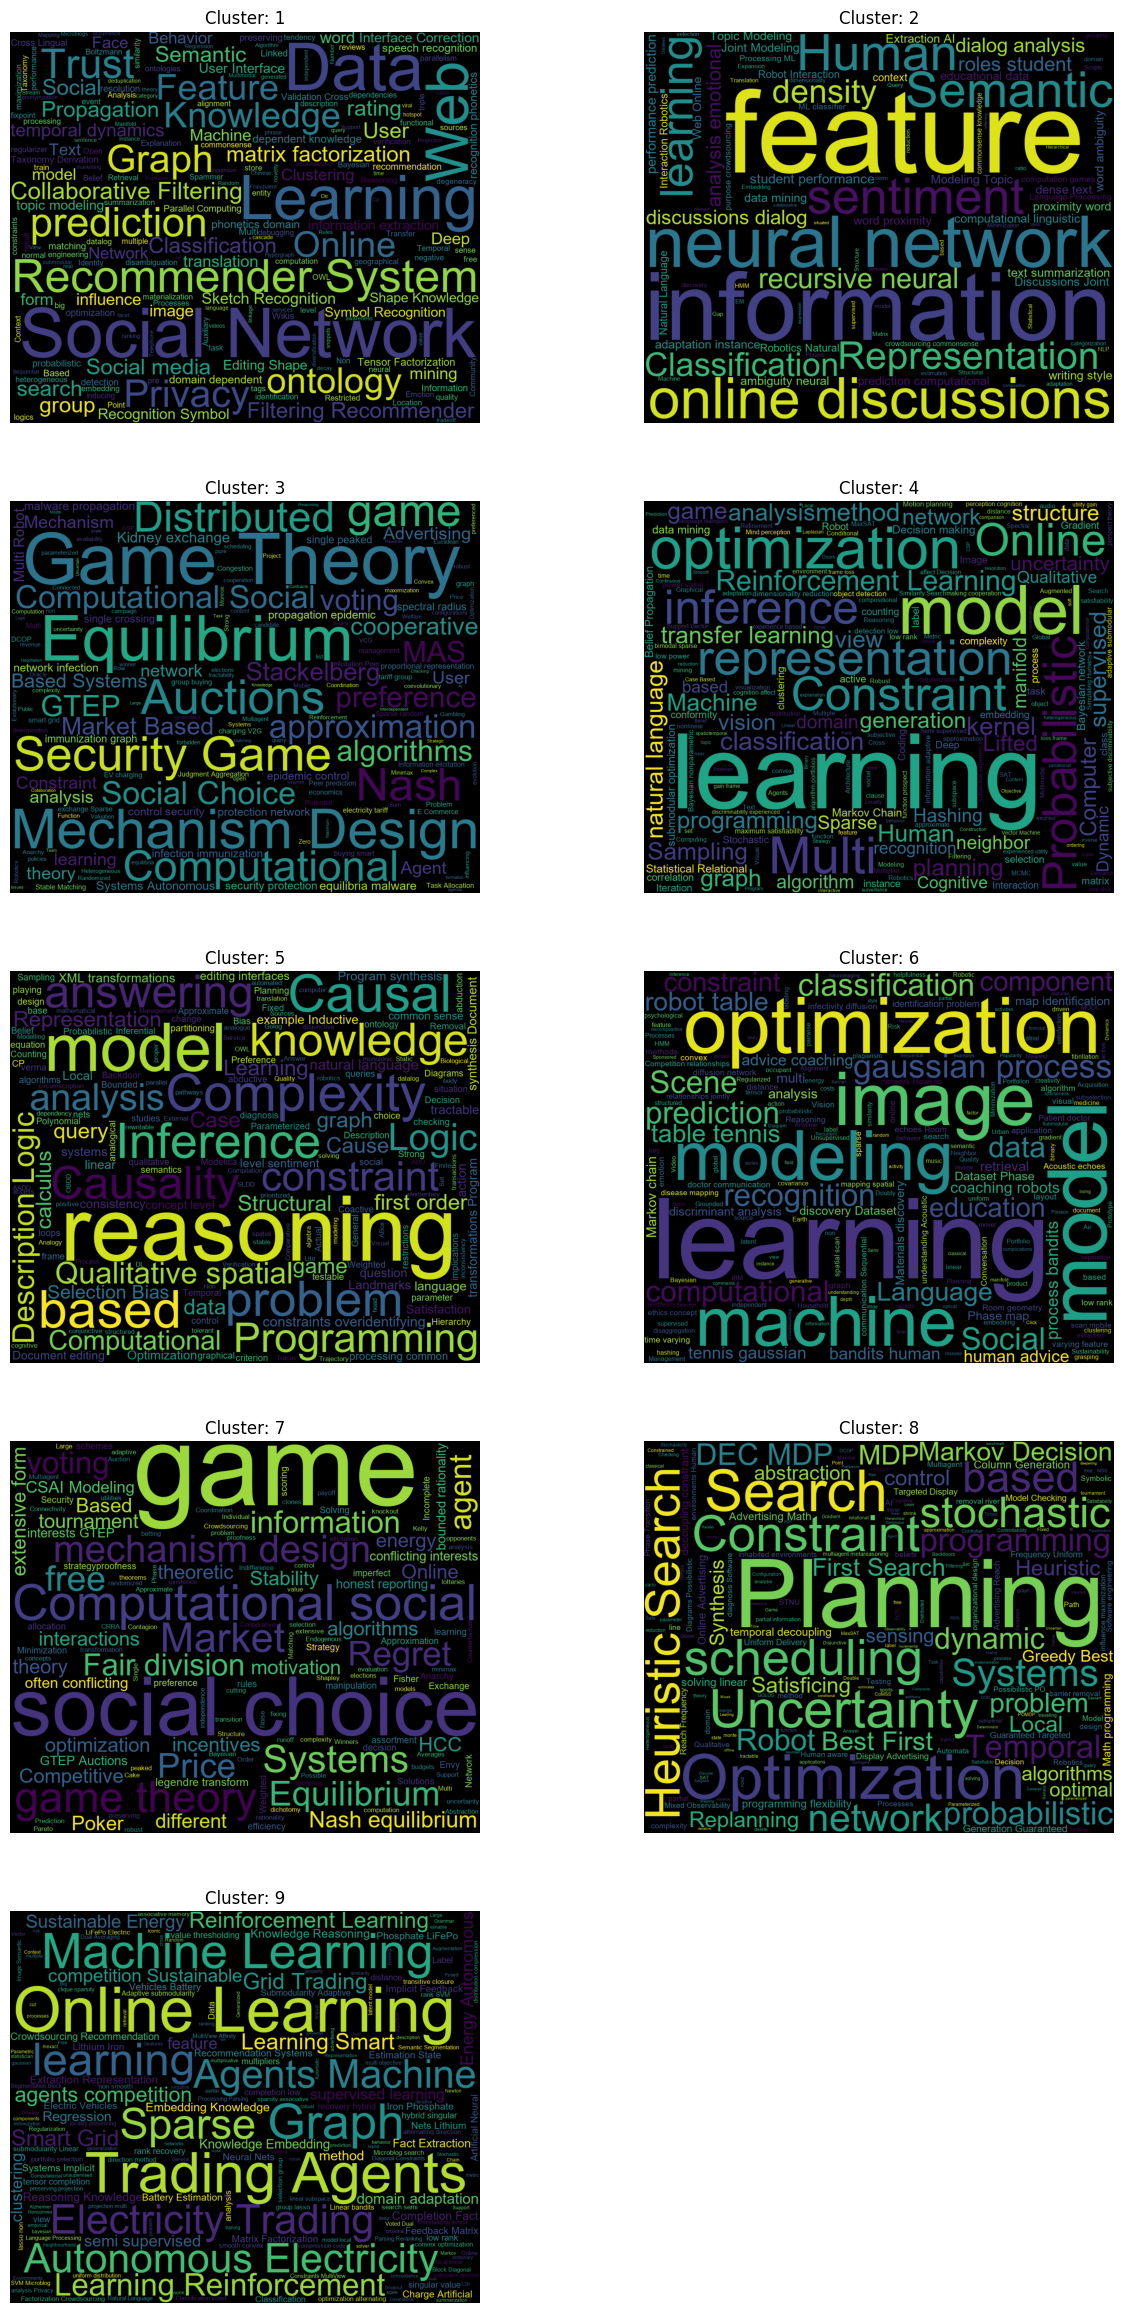

In [29]:
plot_wordcloud(df, gmm.n_components, 'keywords')

**Insights**

Cluster 1: Focus on social networks, recommender systems, collaborative filtering, and online trust/privacy in web environments.

Cluster 2: Emphasis on neural networks, features, sentiment analysis, and online human discussion modeling.

Cluster 3: Core themes include game theory, equilibrium, auctions, security games, and mechanism design.

Cluster 4: Concentration on optimization, probabilistic models, multi-task learning, and reinforcement learning.

Cluster 5: Heavy on causal reasoning, complexity, inference, constraints, and logic-based modeling.

Cluster 6: Dominated by image modeling, optimization, classification, and machine learning in visual domains.

Cluster 7: Discusses social choice, market mechanisms, computational games, and equilibrium in multi-agent systems.

Cluster 8: Planning, heuristic search, constraint satisfaction, and scheduling under uncertainty are key themes.

Cluster 9: Online and reinforcement learning, with specific attention to trading agents, smart grid, and energy systems.